In [21]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import math

# Parameters set

In [22]:
# parameters

t_max = 180             # simulation duration
dt    = 0.01
pop   = 1000000         # total population
b     = 1
m     = 0.04
g     = 0.2 - m
dh    = 0.007
rh    = 0.093
do    = 0.010
ro    = 0.090

# initial state

Sh = 1
Eh = 1
Ih = 1
Rh = 0
Dh = 0

So = 999900
Eo = 0
Io = 97
Ro = 0
Do = 0

ini_state = [Sh, Eh, Ih, Rh, Dh, So, Eo, Io, Ro, Do
    ]

# Defining functions

In [23]:
def sigmoid(a):
    e = math.e
    s = 1 / (1 + e**-a)
    return s

In [24]:
def tSEIRD(v, t, a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap):
    beds = np.sum(ini_state) * cap
    return [
        - b * v[0] * v[2]/ (v[0] + v[1] + v[2]) + m * v[1] - a * v[0], #[0] S_h
        b * v[0] * v[2] / (v[0] + v[1] + v[2]) - (m + g) * v[1] + n * (1 - Sp) * v[6] * sigmoid(beds-(v[0]+v[1]+v[2])), #[1] E_h
        g * v[1] - (rh + dh) * v[2] + p * Se * v[7] * sigmoid(beds-(v[0]+v[1]+v[2])), #[2] I_h
        rh * v[2], #[3] R_h
        dh * v[2], #[4] D_h
        - b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) + m * v[6] + a * v[0], #[5] S_o
        b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) - (m + g) * v[6] - n * (1 - Sp) * v[6] * sigmoid(beds - (v[0]+v[1]+v[2])) ,#[6] E_o
        g * v[6] - (ro + do) * v[7] - p * Se * v[7] * sigmoid(beds - (v[0]+v[1]+v[2])), #[7] I_o
        ro * v[7], #[8] R_o
        do * v[7] #[9] D_o
                ]

In [25]:
def tSEIRD_matrix(Se,Sp,n,p,cap=0.1,a=0):

    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Sh'] = df[0]# / 1000
    df['Eh'] = df[1]# / 1000
    df['Ih'] = df[2]# / 1000
    df['Rh'] = df[3]# / 1000
    df['Dh'] = df[4]# / 1000
    
    df['So'] = df[5]# / 1000
    df['Eo'] = df[6]# / 1000
    df['Io'] = df[7]# / 1000
    df['Ro'] = df[8]# / 1000
    df['Do'] = df[9]# / 1000
    
    df['Susceptible'] = (df[0] + df[5])# / 1000 #10
    df['Exposed']     = (df[1] + df[6])# / 1000 #11
    df['Infectious']  = (df[2] + df[7])# / 1000 #12
    df['Recovered']   = (df[3] + df[8])# / 1000 #13
    df['Dead']        = (df[4] + df[9])# / 1000 #14

    df['Hospitalised']= (df[0] + df[1] + df[2])# / 1000 #15
    df['Outside']     = (df[3] + df[5] + df[6] + df[7] + df[8])# / 1000 #16
    
    df['TP']          = (p * Se * df[7])# / 1000 #17
    df['FP']          = (n * (1 - Sp) * df[6])# / 1000 #18
    df['Positive']    = df['TP'] + df['FP'] #19

    df['all']         = (df[0]+df[1]+df[2]+df[3]+df[4]+df[5]+df[6]+df[7]+df[8]+df[9])# / 1000 #20
    df['beta_in']     = b / df['Hospitalised'] #21
    df['beta_out']    = b / df['Outside'] #22

    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return df_

In [26]:
def tSEIRD_max(Se,Sp,n,p,cap=0.1,a=0):
    
    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Positive'] = (p * Se * df[7]) + (n * (1 - Sp) * df[6])
    df['TP']       = (p * Se * df[7])
    df['FP']       = (n * (1 - Sp) * df[6])

    df['Hospitalised']= df[0] + df[1] + df[2]
    df['Sh'] = df[0]
    df['Eh'] = df[1]
    df['Ih'] = df[2]

    df['Dead']= (df[4] + df[9])
    df['Dh'] = df[4]
    df['Do'] = df[9]
    
    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return [np.max(df_['Positive']),np.max(df_['TP']),np.max(df_['FP']),
            np.max(df_['Hospitalised']),np.max(df_['Sh']),np.max(df_['Eh']),np.max(df_['Ih']),
            np.max(df_['Dead']),np.max(df_['Dh']),np.max(df_['Do'])
           ]

# Heatmaps at prefixed examination behaviour

In [12]:
# generate data

u = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        u.append(tSEIRD_max(i,j,0.7,0.7))
        
np.savetxt('u.csv',u,delimiter=',')

<ipython-input-3-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


In [27]:
# open and tidy data

u = pd.read_csv('u.csv',header=None)

pos_visit_fix   = np.array(u)[:, 0].reshape((101,101))
hosp_visit_fix  = np.array(u)[:, 3].reshape((101,101))
death_visit_fix = np.array(u)[:, 7].reshape((101,101))

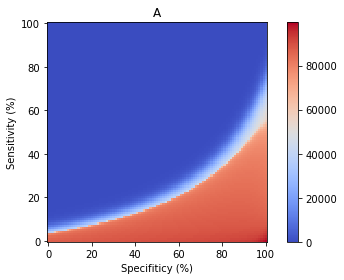

In [28]:
# Fig. 5A

plt.figure()
plt.title('A')
plt.xlabel('Specifiticy (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(death_visit_fix,interpolation='nearest',vmin=0,vmax=np.max(death_visit_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

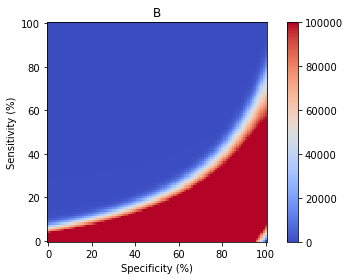

In [29]:
# Fig. 5B

plt.figure()
plt.title('B')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(hosp_visit_fix,interpolation='nearest',vmin=0,vmax=np.max(hosp_visit_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

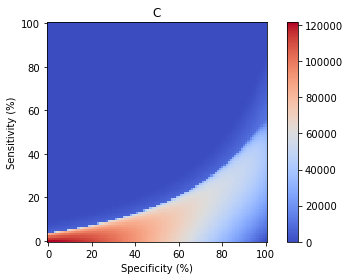

In [30]:
# Fig. 5C

plt.figure()
plt.title('C')
plt.xlabel('Specificity (%)')
plt.ylabel('Sensitivity (%)')
plt.imshow(pos_visit_fix,interpolation='nearest',vmin=0,vmax=np.max(pos_visit_fix),cmap='coolwarm')
plt.colorbar()
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()